# Bigarm-Modellierung mit neuronalen Netzen

Im letzten Schritt wollen wir uns nun unsere statistische Verteilung nicht direkt aus den Trainingsdaten berechnen, sondern diese in einem ganz einfachen neuronalen Netz lernen.

In [ ]:
%pip install torch

In [3]:
# Wir lesen wieder unsere Daten ein - wie bei der statistischen Berechnung ebenfalls

import torch

lines = open("data/vornamenstatistik_24.csv", "r", encoding="utf-8").read().splitlines()
names = list(set([n.split(",")[1] for n in lines][1:]))

sorted_names = sorted(names, key=lambda x: len(x))
count_chars = {}
for w in sorted_names:
    chars = ["<s>"] + list(w) + ["<e>"]
    for c1 in chars:
        count_chars[c1.lower()] = count_chars.get(c1.lower(), 0) + 1
all_chars = list(count_chars.keys())
sorted_chars = sorted(count_chars.items(), key=lambda x: x[1])
frequent_chars = [i for i in all_chars if count_chars[i] >= 10]

N_2 = torch.zeros((len(frequent_chars),len(frequent_chars)), dtype=torch.int32)

for w in sorted_names:
    chars = ["<S>"] + list(w) + ["<E>"]
    for c1, c2 in zip(chars, chars[1:]):
        if c1.lower() in frequent_chars and c2.lower() in frequent_chars:
            id_x = frequent_chars.index(c1.lower())
            id_y = frequent_chars.index(c2.lower())
        # Statt in unserem Dictionary hochzuzählen, zählen wir jetzt an der Matrixposition
        N_2[id_x, id_y] += 1

Schritt 1: Anstatt, dass wir unsere Daten jetzt in einem 2D-Tensor / einer Matrix speichern, speichern wir uns diese als Trainingsdaten ab.
- xs ist unser Eingabedatensatz, also immer der erste Buchstabe in unserem Bigram-Paar
- ys ist unser Ausgabedatensatz, also immer der zweite Buchstabe in unserem Bigram-Paar

In [6]:
xs = []
ys = [] 

for w in names[1:2]:
    print(w)
    chars = ["<s>"] + list(w) + ["<e>"]
    for c1, c2 in zip(chars, chars[1:]):
        id_x = frequent_chars.index(c1.lower())
        id_y = frequent_chars.index(c2.lower())
        xs.append(id_x)
        ys.append(id_y)


# Die Listen konvertieren wir noch zu Tensoren
xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs, ys

Ivana


(tensor([ 0, 14, 11,  1,  2,  1]), tensor([14, 11,  1,  2,  1,  3]))

Schritt 2: Um unsere Daten besser in die neuronalen Netze füttern zu können, konvertieren wir unsere Input-Daten jetzt noch in ein "Bag-of-Words". Dabei wird ein Buchstabe nicht mehr als Zahl / Index in einer Liste repräsentierert, sondern wir nutzen eine Vektor-Schreibweise. In diesem Vektor gibt es so viele Zeilen wie wir Buchstaben haben. Diese sind mit Nullen gefüllt. Und jetzt setzen wir nur den Index auf 1, der dem Index unseres Buchstabens entsprocht. 
Statt dass wir zum Beispiel M = 14 eingeben, geben wir einen Vektor ein, der an allen Stellen eine 0 hat, ausser an der 14. eine 1.

In [7]:
import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=len(frequent_chars)).float()  # float conversion ist elementar für Input in NN
xenc.shape
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Wir erstellen uns noch mal einen Plot, um das ganze einfacher zu veranschaulichen.

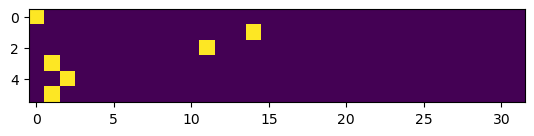

In [8]:
import matplotlib.pyplot as plt
plt.imshow(xenc)

Schritt 3: Jetzt haben wir alles vorbereitet, um unsere Gewichtsmatrix in unserem neuronalen Netz zu trainieren. In diesem simplen Beispiel verzichten wir noch auf einige Terme aus unserem neuronalen Netz - wir nehmen simplifiziert an, dass y = x * W gilt.

In [10]:
# Wir füllen unsere Gewichte am Anfang einfach random
g = torch.Generator().manual_seed(42)
W = torch.randn((len(frequent_chars), len(frequent_chars)), generator=g) 
W

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.0418, -0.2516,  0.8599],
        [-1.3847, -0.8712, -0.2234,  ...,  1.8446, -1.1845,  1.3835],
        [ 1.4451,  0.8564,  2.2181,  ..., -0.8278,  1.3347,  0.4835],
        ...,
        [ 0.0518, -0.3285, -2.2472,  ...,  1.4557, -0.3461, -0.2634],
        [-0.4477, -0.7288, -0.1607,  ...,  0.5405,  0.4351, -2.2717],
        [-0.1339, -0.0586,  0.1257,  ...,  1.1085,  0.5544,  1.5818]])

Wir haben jetzt noch nichts gelernt, wir haben nur zufällig unsere Gewichte initialisiert. Aber wir können jetzt überprüfen, wie gut unsere Initialisierung war, in dem wir uns einfach eine vorhersage von y ausrechnen

In [11]:
y_pred = xenc @ W
y_pred

tensor([[ 1.9269e+00,  1.4873e+00,  9.0072e-01, -2.1055e+00,  6.7842e-01,
         -1.2345e+00, -4.3067e-02, -1.6047e+00, -7.5214e-01,  1.6487e+00,
         -3.9248e-01, -1.4036e+00, -7.2788e-01, -5.5943e-01, -7.6884e-01,
          7.6245e-01,  1.6423e+00, -1.5960e-01, -4.9740e-01,  4.3959e-01,
         -7.5813e-01,  1.0783e+00,  8.0080e-01,  1.6806e+00,  1.2791e+00,
          1.2964e+00,  6.1047e-01,  1.3347e+00, -2.3162e-01,  4.1759e-02,
         -2.5158e-01,  8.5986e-01],
        [-1.3839e+00,  4.8687e-01, -1.0020e+00,  3.2949e-02, -4.2920e-01,
         -9.8180e-01, -6.4206e-01,  8.2659e-01,  1.5914e+00, -1.2081e-01,
         -4.8302e-01,  1.1330e-01,  7.7151e-02, -9.2281e-01, -1.2620e+00,
          1.0861e+00,  1.0966e+00, -6.8369e-01,  6.6043e-02, -7.7380e-04,
          1.6206e-01,  1.1960e+00, -1.3062e+00, -1.4040e+00, -1.0597e+00,
          3.0573e-01,  4.1506e-01, -7.1741e-01,  2.8340e+00,  1.9535e+00,
          2.0487e+00, -1.0880e+00],
        [-7.9394e-01,  3.7523e-01,  8.79

Schritt 4: Wir würden den Output jetzt gern wieder in etwas umwandeln, das leichter zu interpretieren ist - Eine Wahrscheinlichkeitsverteilung. 
Dafür können wir Softmax verwenden, damit können wir jeden Output in eine Wahrscheinlichkeitsverteilung transferieren.

Softmax: https://de.wikipedia.org/wiki/Softmax-Funktion 

In [13]:
probs = y_pred.exp() /y_pred.exp().sum(1, keepdims = True)
probs

tensor([[0.1063, 0.0685, 0.0381, 0.0019, 0.0305, 0.0045, 0.0148, 0.0031, 0.0073,
         0.0805, 0.0105, 0.0038, 0.0075, 0.0088, 0.0072, 0.0332, 0.0800, 0.0132,
         0.0094, 0.0240, 0.0073, 0.0455, 0.0345, 0.0831, 0.0556, 0.0566, 0.0285,
         0.0588, 0.0123, 0.0161, 0.0120, 0.0366],
        [0.0038, 0.0247, 0.0056, 0.0157, 0.0099, 0.0057, 0.0080, 0.0347, 0.0746,
         0.0135, 0.0094, 0.0170, 0.0164, 0.0060, 0.0043, 0.0450, 0.0455, 0.0077,
         0.0162, 0.0152, 0.0179, 0.0503, 0.0041, 0.0037, 0.0053, 0.0206, 0.0230,
         0.0074, 0.2585, 0.1072, 0.1179, 0.0051],
        [0.0071, 0.0229, 0.0172, 0.0045, 0.0114, 0.0068, 0.0091, 0.1148, 0.1051,
         0.0856, 0.0162, 0.0132, 0.0027, 0.0078, 0.0106, 0.1037, 0.0126, 0.0186,
         0.1341, 0.0864, 0.0222, 0.0299, 0.0128, 0.0312, 0.0137, 0.0048, 0.0044,
         0.0246, 0.0087, 0.0369, 0.0096, 0.0110],
        [0.0052, 0.0086, 0.0165, 0.1148, 0.0283, 0.0135, 0.0280, 0.0095, 0.0043,
         0.0558, 0.0085, 0.0113, 0.0058,

Wir können jetzt für verschiedene W-initialisierungen ausprobieren, wie unterschiedlich der Output ist.
Intuitiv wollen wir jetzt also W solange verändern, dass der Output für unsere realen Beispiele (unsere Trainingsdaten) möglichst hoch ist. Das machen wir in der Praxis natürlich nicht, in dem wir einfach so lange zufällige Verteilungen testen, bis wir eine gute gefunden haben. Stattdessen wollen wir jetzt W langsam so anpassen, dass die Vorhersagen immer besser werden. Oder in anderen Worten: Das unser Loss immer kleiner wird.

In [14]:
xs = []
ys = [] 

for w in names:
    chars = ["<s>"] + list(w) + ["<e>"]
    valid = True
    for c in list(w): # Den Teil müssen wir einbauen, um nur Kombinationen mit unseren häufigen Buchstaben zuzulassen
        if c.lower() not in frequent_chars:
            valid = False
    if valid:
        for c1, c2 in zip(chars, chars[1:]):
            id_x = frequent_chars.index(c1.lower())
            id_y = frequent_chars.index(c2.lower())
            xs.append(id_x)
            ys.append(id_y)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

xenc = F.one_hot(xs, num_classes=len(frequent_chars)).float() 
res = xenc @ W
probs = res.exp() / res.exp().sum(1, keepdims = True)

sum_log = 0
for c in range(len(xs)):
    x = xs[c].item()
    y = ys[c].item()
    p = probs[c, y]
    logp = torch.log(p)
    nll = -logp
    sum_log += nll
print(sum_log / len(xs))

# Hier noch ein etwas hüberer Weg das ganze zu schreiben
loss = -probs[torch.arange(len(xs)), ys].log().mean()
print(loss)

tensor(3.9718)
tensor(3.9718)


Wenig überraschend haben wir hier ein höheren Loss als wir ihn in unserer intuitiven statistischen Modellierung haben. Aber wir haben das Netz ja auch noch nicht trainiert!
Was wir bisher gemacht haben nennt man einen Foward-Pass: Wir haben Trainingsdaten in unser Netz gesteckt und uns ausgerechnet, wie gut das momentan "trainierte" Netz funktioniert.

Schritt 5: Jetzt trainieren wir unser Netz tatsächlich. Dafür fügen wir unserem foward-pass jetzt einen back-ward pass hinzu: Wir lassen Torch den Gradienten berechnen und korrigieren auf Grund dessen unsere Gewichtsmatrix entsprechend.

In [20]:
g = torch.Generator().manual_seed(42)
W = torch.randn((len(frequent_chars), len(frequent_chars)), generator=g, requires_grad=True) # Nicht vergessen hier requires_grad auf True zu setzen, damit python weiß, dass wir hier später Gradienten für berechnen wollen

In [21]:
# forward pass
xenc = F.one_hot(xs, num_classes=len(frequent_chars)).float()
logits = xenc @ W
counts = logits.exp() 
probs = counts / counts.sum(1, keepdims=True) 
loss = -probs[torch.arange(len(xs)), ys].log().mean()
print(loss.item())

3.9718308448791504


In [22]:
# backward pass
W.grad = None
loss.backward()
W.grad

tensor([[ 1.5558e-02, -8.6826e-03, -1.1017e-03,  ...,  2.0050e-03,
          1.7614e-03,  5.3523e-03],
        [ 7.4337e-04,  3.2472e-04, -2.1021e-02,  ...,  1.8677e-02,
         -1.2327e-03,  1.1842e-02],
        [ 5.8536e-03, -1.1074e-02,  7.3277e-03,  ...,  6.0299e-04,
          4.7319e-03,  2.2377e-03],
        ...,
        [ 1.9740e-05, -3.7476e-05,  1.9810e-06,  ...,  8.0364e-05,
          1.3260e-05,  1.4403e-05],
        [ 7.1615e-05, -3.0273e-04, -2.1040e-04,  ...,  1.9238e-04,
          1.7314e-04,  1.1557e-05],
        [ 1.0567e-05,  1.1393e-05,  1.3699e-05,  ...,  3.6600e-05,
          2.1031e-05,  5.8752e-05]])

In [23]:
# update
W.data += -0.1 * W.grad

Wenn wir jetzt die Gewichte updaten und das immer wieder machen, dann sehen wir, dass der loss langsam nach unten geht. Wir haben etwas gelernt - yay!

In [26]:
for i in range(500): # Hier kann geändert werden, wie viele Trainingsdurchläufe wir durchführen
    # forward pass
    xenc = F.one_hot(xs, num_classes=len(frequent_chars)).float() 
    logits = xenc @ W 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(len(xs)), ys].log().mean()
    # print(loss.item())

    # backward pass
    W.grad = None 
    loss.backward()

    # update
    W.data += -10 * W.grad # Der Parameter hier ist die Learning Rate
print(loss.item())

2.484388828277588


Wir sehen, dass der Loss über die Zeit beständig fällt. Und wenn wir das Training sehr oft durchführen, dann erhalten wir ungefähr den gleichen Loss, wie wir in unserem Originaldatensatz auch vorliegen hatten.
Mehr kann das Netz nun nicht mehr lernen: Es hat aus den Trainingsdaten das Optimum herausgeholt.

Schritt 6: Als letztes nutzen wir noch unser trainiertes Netzwerk, und lassen uns daraus neue Namen generieren. 
Weil wir ja kein wirkliches Netz trainiert haben, müssen wir auch hier wieder ein bisschen mogeln und einfach wieder mit der trainierten Wahrscheinlichkeitsverteilung die nächste Auswahl treffen.

In [27]:
g = torch.Generator().manual_seed(42)

generated_names = []
for i in range(0, 10):
    curr_char = "<s>"
    name = ""
    while curr_char != "<e>":
        xenc = F.one_hot(torch.tensor([frequent_chars.index(curr_char)]), num_classes=len(frequent_chars)).float()
        res = xenc @ W 
        p = res.exp() / res.exp().sum(1, keepdims=True)
        
        ind = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = frequent_chars[ind]
        curr_char = char
        name += curr_char
    generated_names.append(name[:-3])
generated_names

['adria', 'f', 'maná-ka', 'dka', 'yanaréla', 'e', 'la', 'gada', 'l', 'cha']

Auch hier sehen wir wiede die gleichen Probleme wie bei unserer simplen statistischen Berechenung. Aber das war zu erwaten - wir haben ja bisher nur ein sehr einfaches, lineares Netz trainiert, und ihm auch nur einen sehr kleinen Kontext zum lernen zur Verfügung gestellt.
Trotzdem haben wir jetzt unser erstes eigenes Mini-Language-Model erschaffen!